# Scientific Presentation Script Generator

This notebook uses the RAG (Retrieval-Augmented Generation) architecture to generate a scientific presentation script. The process involves searching for a paper related to a specific topic using the arXiv API. After the search, the necessary pipelines are applied to format and generate a cohesive and informative presentation script.

## RAG with Galileo, Langchain and GPT

- What is RAG?

Retrieval-Augmented Generation (RAG) is an architectural approach that can enhance the effectiveness of large language model (LLM) applications using customized data. In this example, we use LangChain, an orchestrator for language pipelines.

## Step 0: Configuring the environment
This step install the necessary libraries for connecting with Galileo and the models




In [ ]:
%pip install --upgrade --quiet  feedparser newspaper3k listparser
!pip install PyMuPDF


### Local Environment
If you want to run models locally using Llama-cpp, just execute the following cell:

Learn more at: https://python.langchain.com/docs/integrations/llms/llamacpp/


## Chapter 1: Building the Paper Research and Processing Pipeline
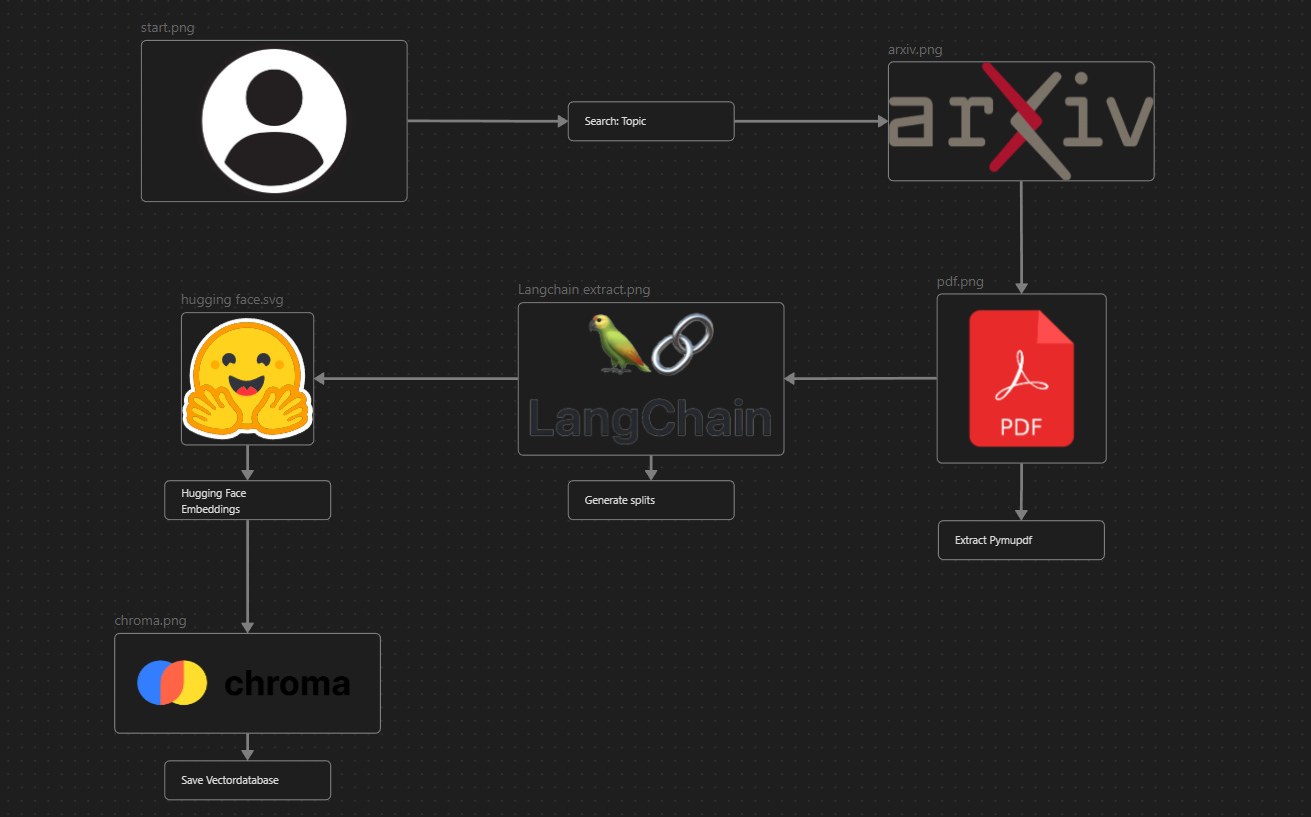
In this chapter, we will build a complete pipeline for researching and processing scientific papers. The process will be detailed in several stages:

1. **Paper Research**: We will start by selecting a specific topic to search for relevant papers. The research will be conducted using specialized APIs, such as the arXiv API.
2. **Paper Download**: After identifying the paper of interest, we will download the file to store it locally.
3. **Text Extraction**: Once the paper is saved, we will use the PyMuPDF library to extract the text from the PDF document.
4. **Chunk Creation**: The extracted text will be segmented into small blocks, called "chunks," using the LangChain framework.
5. **Embedding Generation**: Each chunk will be converted into a vector representation using Hugging Face's embedding models. This representation allows for semantic analysis of the content.
6. **Storage in the Vector Database**: Finally, the generated embeddings will be stored in a vector database, which in our case will be ChromaDB. 

## Step 1: Search Papers

In this step, the pipeline performs a search for relevant scientific papers using the arXiv API.

1. **Query Definition**: The user provides a term or topic of interest (query), which is used to search for papers on arXiv. The search can be refined by specifying the maximum number of results returned        (max_results), with the default value being 1.

2. **Request Submission**: The search_arxiv_and_extract_text function sends an HTTP request to the arXiv API with the specified query. The API returns information about the papers that match the search term.

3. **Response Processing**: If the request is successful, the response content (in XML format) is processed to extract information about each paper found. Specifically, the function retrieves the paper's        title and the corresponding PDF link.

4. **PDF Download**: Using the PDF link, the pipeline downloads the document locally using the download_pdf function, which saves the file in a temporary directory.

5. **Text Extraction**: After the download, the text from the PDF is extracted using the PyMuPDF library. The extracted text is then consolidated and presented in a string format, which can be used in later stages for embedding generation.



In [ ]:
import requests
import xml.etree.ElementTree as ET
from langchain_community.document_loaders import PyMuPDFLoader


In [ ]:
def search_arxiv_and_extract_text(query, max_results=1):
    """
    Searches arXiv for articles based on a query and extracts the text from the associated PDF.

    Parameters:
    - query (str): The search term to use in the arXiv search.
    - max_results (int): The maximum number of results to return from the search. Default is 1.
    
    Returns:
    - papers (list): A list of dictionaries containing 'title' and 'text' for each article.
    """
    url = f'http://export.arxiv.org/api/query?search_query=all:{query}&start=0&max_results={max_results}'
    response = requests.get(url)
    
    papers = []  
    
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        
        for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
            title = entry.find('{http://www.w3.org/2005/Atom}title').text
            pdf_url = None
            
            for link in entry.findall('{http://www.w3.org/2005/Atom}link'):
                if link.attrib.get('type') == 'application/pdf':
                    pdf_url = link.attrib['href']
                    break
            
            if pdf_url:
                pdf_path = f"temp_{title[:50].strip().replace(' ', '_')}.pdf"
                pdf_downloaded = download_pdf(pdf_url, pdf_path)
                
                if pdf_downloaded:
                    loader = PyMuPDFLoader(pdf_path)
                    docs = loader.load()
                    text = "\n".join([doc.page_content for doc in docs])
                    
                    papers.append({
                        'title': title.strip(),
                        'text': text
                    })
                    print(f"Text extracted from the article '{title.strip()}':\n{text[:500]}...")
                else:
                    print(f"Error downloading article PDF '{title.strip()}'.")
            else:
                arxiv_url = entry.find('{http://www.w3.org/2005/Atom}id').text
                print(f"No PDF link found for the article '{title.strip()}'. You can view it online here: {arxiv_url}")
    else:
        print("Error accessing arXiv.")
    
    return papers

def download_pdf(pdf_url, output_path):
    """
    Downloads a PDF file from a URL and saves it locally.

    Parameters:
    - pdf_url (str): The URL of the PDF to be downloaded.
    - output_path (str): The path where the PDF will be saved locally.
    """
    response = requests.get(pdf_url)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            f.write(response.content)
        return True
    else:
        print(f"Error downloading PDF: {response.status_code}")
        return False

In [ ]:
query = "RAG"  
papers = search_arxiv_and_extract_text(query, max_results=1)

In [ ]:
papers

## Step 2:  Processing and Embedding Generation

1. **Document Creation**: The first step is to transform the text of the papers into Document objects, which are structures used by LangChain to manipulate and process textual content.
2. **Text Splitting**: Once the text of the papers is encapsulated in Document objects, the next step is to segment them into smaller "chunks." This is done using the RecursiveCharacterTextSplitter, a LangChain tool that divides the text into smaller blocks to facilitate subsequent processing. The chunk_size defines the maximu
3. **Embedding Generation**: After the text segmentation, the next step is to convert these chunks into embeddings, which are vector representations of the text. This is accomplished using the HuggingFaceEmbeddings class, which leverages language models from Hugging Face to create these representations.

In [ ]:
# Import the Document class to structure the text and its metadata 
# Import the RecursiveCharacterTextSplitter to split the text into smaller parts
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Creates a list of Document objects from the scientific articles in the `papers` variable.
# Each `Document` is created with the article content and a metadata dictionary containing the title.
documents = [Document(page_content=paper['text'], metadata={"title": paper['title']}) for paper in papers]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=400)
splits = text_splitter.split_documents(documents)



In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings= HuggingFaceEmbeddings()



## Step 3: Vector Data Storage and Retrieval

In this step, the pipeline stores the generated embeddings in a vector database and implements a similarity search function for specific queries.

1. **Embedding Storage**: The previously segmented text chunks, which have been converted into embeddings, are stored in a vector database using Chroma.
2. **Retriever Configuration**: Once the embeddings are stored in Chroma, the next step is to configure a "retriever." This retriever is responsible for performing similarity searches within the vector database, allowing you to retrieve the most relevant embeddings based on a specific query.
3. **Similarity Search Function**: The query_vectordb function is defined to perform similarity searches in the vector database. It accepts a query as input and returns the top k most similar results, where k is an adjustable parameter (with the default being 10).

In [ ]:
from langchain.vectorstores import Chroma
#Our vector database
vectordb = Chroma.from_documents(documents=splits, embedding=embeddings)


In [ ]:
retriever = vectordb.as_retriever()


In [ ]:
def query_vectordb(vectordb, query, k=10):
    """
    Performs a similarity search in a vector database.
    Parameters:
    - vectordb: The vector database where the embeddings are stored.
    - query: The query that will be used to search for the most similar embeddings in the database.
    - k: The number of most similar results that should be returned (default is 10).
    """
    return vectordb.similarity_search(query, k=k)

In [ ]:
query = "LLM"
query_vectordb(vectordb, query)

## Chapter 2: Building a Prompt Flow for Generating Scientific Presentation Scripts
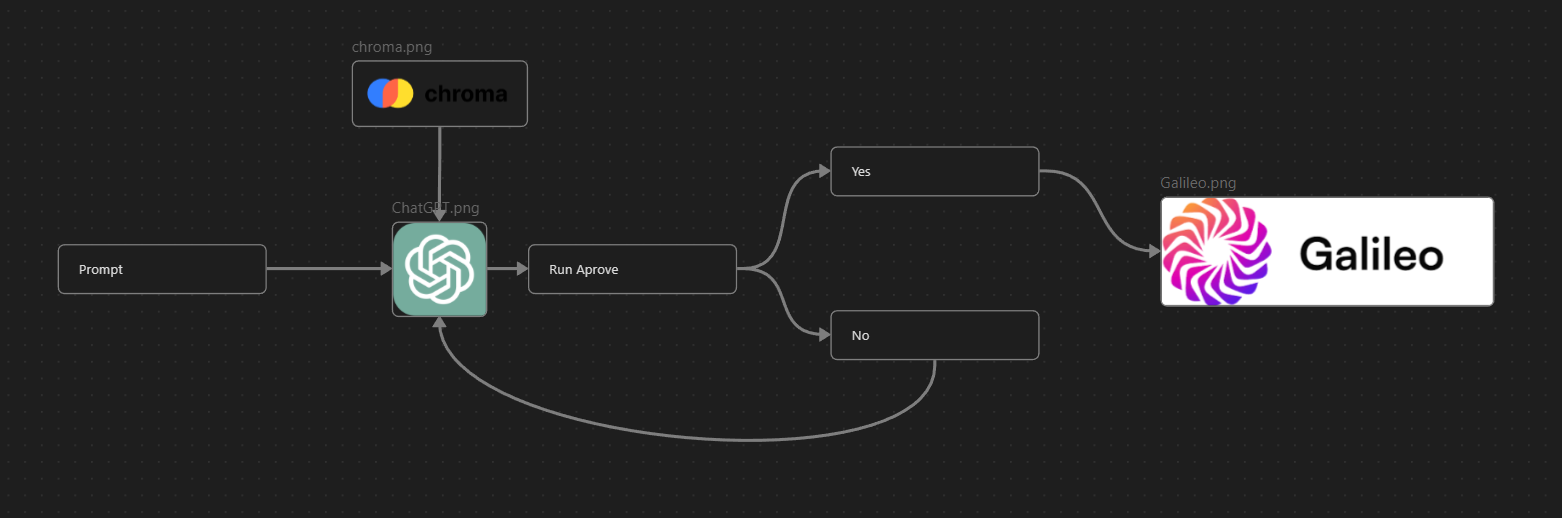

In this chapter, we will create a prompt flow with the goal of building a script for scientific presentations using GPT-3.5. To achieve this, we will follow a process in which each section of the script (such as the title, introduction, methodology, etc.) will be generated individually, using a specific "Prompt Template" for each part.


1. Defining the Prompt Template::
   - For each section of the script, such as the title, introduction, and conclusion, we define a "Prompt Template" in string format. This template contains the instructions that the GPT-3.5 model will follow to generate the desired text.
   - For example, for the title, the template might be: :``` Generate a title for the presentation that is clear, concise, and reflects the content. Add a subtitle if needed. ```
2. Executing Text Generation:
    - We use a function called run_and_approve that takes the prompt template and a specific task, such as "create a title" or "generate an introduction..
    - This function executes the text generation based on the template, showing the result to the user for approval.
3. Logging Metrics with Galileo::
    - Each time the model successfully generates text and the user approves it, the metrics related to the generation process are logged and sent to Galileo, a tool used to monitor and evaluate the quality of the prompts and the model's responses.
    - This allows for a detailed record of the model's performance in generating the different parts of the scientific presentation script..
4. Creating Each Part of the Script:
   - The process is repeated for each part of the script: title, introduction, methodology, results, conclusion, and references.
   - For each of these sections, the model generates text according to the instructions in the template, and the user approves or rejects the result..


#### Step 4: Config Enviroment

In this step, we log in using the Galileo and OpenAI APIs.

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
os.environ['GALILEO_API_KEY'] = ''  # Replace with your API key
os.environ['GALILEO_CONSOLE_URL'] = 'https://console.hp.galileocloud.io/'
GALILEO_PROJECT_NAME = 'Academic Script'
config = pq.login(os.environ['GALILEO_CONSOLE_URL'])

In [ ]:
from typing import List
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema import StrOutputParser
import promptquality as pq
from promptquality import NodeRow, NodeType
import uuid

def format_docs(docs: List[Document]) -> str:
    """
    Function that formats the contents of a list of documents into a single string.
    Parameters:
    - docs (List[Document]): List of Document objects, where each document contains a textual content.

    Returns:
    - str: A single string that joins the content of all documents, separated by two line breaks.
    
    """
    formatted_docs = "\n\n".join([d.page_content for d in docs])
    return formatted_docs

template = """You are tasked with analyzing a scientific paper and responding to a series of steps or questions based on the paper's content. 
Your goal is to provide accurate, contextual responses for each step, drawing from the paper's information and your own knowledge when necessary.
Here is the paper you will be analyzing:
    {context}

1. Read the step carefully.
2. Search for relevant information in the paper that addresses the step.
3. If the paper contains information directly related to the step, use that information to formulate your response.
4. If the paper does not contain information directly related to the step, but the topic is related to the paper's content, use your own knowledge to provide a response that is consistent with the paper's context and subject matter.
    Question: {question}
    """
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()

chain = {
    "context": lambda inputs: format_docs(query_vectordb(vectordb, inputs['query'])), 
    "question": RunnablePassthrough()
} | prompt | model | StrOutputParser()



### Local Model config

If you want to run with local model using LlamaCPP prompt | llm_local


In [ ]:
"""
Instantiate your local model with `llama.cpp`

"""
### Alternate code to load local models. 
###This specific example requires the project to have an asset call Llama7b, associated with the cloud S3 URI s3://dsp-demo-bucket/LLMs (public bucket)

# Instantiate your local model with `llama.cpp`

#from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
#from langchain_community.llms import LlamaCpp

# Initialize the callback manager, which handles streaming output
#callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

# Configure the local model using `LlamaCpp`
#llm_local = LlamaCpp(
#    model_path="/home/jovyan/datafabric/Llama7b/ggml-model-f16-Q5_K_M.gguf",  # Path to the model
#    n_gpu_layers=64,  # Number of model layers to be processed on the GPU
#    n_batch=512,  # Batch size for processing
#    n_ctx=4096,  # Context size for tokenization
#    max_tokens=1024,  # Maximum number of tokens for generation
#    f16_kv=True,  # Use 16-bit precision for key-value storage
#    callback_manager=callback_manager,  # Callback manager for streaming output
#    verbose=False,  # Sets verbosity (whether detailed logs should be shown)
#    stop=[],  # Tokens to stop the generation
#    streaming=False,  # Sets whether the output should be streamed in real-time
#    temperature=0.4  # Controls the randomness of the model's responses
#)

# Combine the prompt with the configured local model (`llm_local`)
#llm_chain = prompt | llm_local


In [ ]:
"""
Chain with Local model
"""

#from typing import List
#from langchain.prompts import ChatPromptTemplate
#from langchain.schema.runnable import RunnablePassthrough
#from langchain.schema import StrOutputParser
#import uuid

#def format_docs(docs: List[Document]) -> str:
#    return "\n\n".join([doc.page_content for doc in docs])

#template = """You are a Python wizard tasked with generating code for a Jupyter Notebook (.ipynb) based on the given context.
#Your answer should consist of just the Python code, without any additional text or explanation.

#Context:
#{context}

#Question: {question}
#"""

#prompt = ChatPromptTemplate.from_template(template)

#model = llm_local()

#chain = {
#    "context": lambda inputs: format_docs(retriever(inputs['query'], collection)),  
#    "question": RunnablePassthrough()  
#} | prompt | model | StrOutputParser()


### Run and approve

The run_and_approve function is designed to interactively generate text based on a prompt template and a specific question, retrieving context from a vector database. It provides an iterative mechanism to approve or reject the generated output manually. If the output is not approved, the function will regenerate the response until it meets the user's criteria.

In [ ]:
import time

def run_and_approve(variable_name, template, question, vectordb, k=10):
    """
    Function that executes a chain of prompts to generate text based on a template and a question,
    with the option of manually approving the result.

    Parameters:
    - variable_name (str): Name of the variable to be used when printing the result.
    - template (str): Prompt template that will be used as context to generate the text.
    - question (str): Specific task that the model must perform, such as "create a title" or "generate an introduction".
    - vectordb: Vector database used to search for documents related to the context.
    - k (int, optional): Number of documents to be retrieved from the vector database. The default is 5.

    Returns:
    - str: The text generated and approved by the user based on the template and the question.
    """
    while True:
        # Configure a new prompt_handler for each step
        prompt_handler = pq.GalileoPromptCallback(
            scorers=[
                pq.Scorers.context_adherence_plus,
                pq.Scorers.correctness,
                pq.Scorers.prompt_perplexity
            ]
        )

        # Execute the chain in batch with the template as query and a specific question
        result = chain.batch([{"query": template, "question": question}], config=dict(callbacks=[prompt_handler]))

        if not result:
            continue

        # Print the variable name and result
        print(f"{variable_name}: {result[0]}")

        approval = input("Approve the result? (y/n): ").strip().lower()
        if approval == 'y':
            # Finalize and send the prompt to Galileo
            prompt_handler.finish()
            return result[0]  # Return the approved result

        print("Result not approved, generating again...\n")

# Example execution for each cell


title_template = """
Generate a title for the presentation that is clear, concise, and reflects the content. Add a subtitle if needed.
"""
title_result = run_and_approve("title_template", title_template, question="create a title", vectordb=vectordb)

# Introduction
introduction_template = """
Generate an introduction that includes:
- Contextualization of the general theme.
- Relevance of the topic, both academically and practically.
- A brief literature review.
- A clear definition of the research problem.
- The specific objectives of the research.
- Hypotheses (if applicable).
"""
introduction_result = run_and_approve("introduction_template", introduction_template, question="generate an introduction", vectordb=vectordb)

# Methodology
methodology_template = """
Generate the methodology section, including:
- Research Design (e.g., experimental, descriptive, exploratory).
- Sample and Population details.
- Data Collection methods.
- Instruments used for data collection.
- Data Analysis techniques.
"""
methodology_result = run_and_approve("methodology_template", methodology_template, question="generate the methodology", vectordb=vectordb)

#  Results
results_template = """
Generate the results section, including:
- Presentation of Data with visual aids like graphs and tables.
- Initial Interpretation of the data.
- Comparison with Hypotheses (if applicable).
"""
results_result = run_and_approve("results_template", results_template, question="generate the results", vectordb=vectordb)

# Conclusion
conclusion_template = """
Generate the conclusion of the study, including:
- Synthesis of Results.
- Response to the Research Problem.
- Study Contributions.
- Final Reflection on the study's impact or practical recommendations.
"""
conclusion_result = run_and_approve("conclusion_template", conclusion_template, question="generate the conclusion", vectordb=vectordb)

# References
references_template = """
Generate the list of references for the study, ensuring that:
- All sources cited in the presentation are included.
- The references are formatted according to a specific style (APA, MLA, Chicago).
"""
references_result = run_and_approve("references_template", references_template, question="generate the references", vectordb=vectordb)

# Combine the results into a final script
final_script = f"{title_result}\n\n{introduction_result}\n\n{methodology_result}\n\n{results_result}\n\n{conclusion_result}\n\n{references_result}"
print("Final Script:\n", final_script)


Approve the result? (y/n):  y


Processing chain run...:   0%|          | 0/5 [00:00<?, ?it/s]

Initial job complete, executing scorers asynchronously. Current status:
cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Failed ❌, error was: Calculating the metric perplexity requires credentials for OpenAI or Azure to be set.
latency: Done ✅
groundedness: Failed ❌, error was: Executing this metric requires credentials for OpenAI or Azure OpenAI service to be set.
factuality: Failed ❌, error was: Executing this metric requires credentials for OpenAI or Azure OpenAI service to be set.
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/34e526a8-6799-42b5-b2a6-26e582ace815/aa638463-29b3-4970-ba3c-b66786a7d76b?taskType=12
references_template: To generate the list of references for the study, we need to include all the sources cited in the presentation. However, since the provided text is an excerpt from a scientific paper and does not contain any specific citations or references, we are unable to generate a

Approve the result? (y/n):  y


Processing chain run...:   0%|          | 0/5 [00:00<?, ?it/s]

Initial job complete, executing scorers asynchronously. Current status:
cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Failed ❌, error was: Calculating the metric perplexity requires credentials for OpenAI or Azure to be set.
latency: Done ✅
groundedness: Failed ❌, error was: Executing this metric requires credentials for OpenAI or Azure OpenAI service to be set.
factuality: Failed ❌, error was: Executing this metric requires credentials for OpenAI or Azure OpenAI service to be set.
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/4e3f3df7-098e-4d71-b123-959e682d02b2/895c2227-8310-4465-93e2-fb43f9810254?taskType=12
Final Script:
 Title: "Machine Teaching: A Paradigm Shift in Education"
Subtitle: "Exploring the Potential of Teaching Computers to Learn Tasks"

Introduction:

In the field of machine learning and artificial intelligence, the concept of generalization plays a crucial role in enabling comp